In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
results = inspector.get_columns('Measurement')
for record in results:
    print(record)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [10]:
results = inspector.get_columns('Station')
for record in results:
    print(record)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(results[0])

2017-08-23


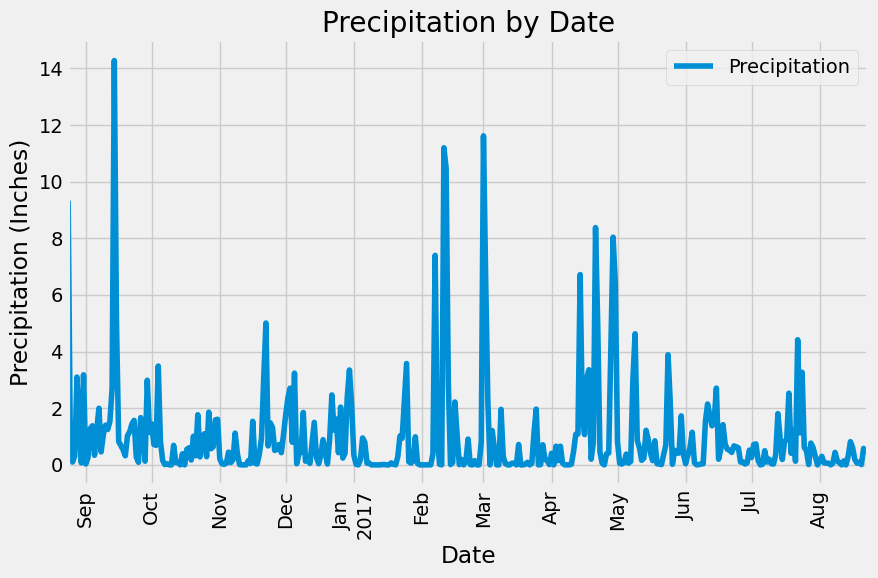

In [12]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
last_year = dt.datetime(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year)
# for record in results:
#     print(record)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results)
df = df.rename(
columns = {
    'date' : 'Date',
    'prcp' : 'Precipitation'
})
df.dropna(axis = 0, how = 'any', inplace = True)

# Sort the dataframe by date
df.sort_values(by = 'Date')
df_group = df.groupby('Date')['Precipitation'].sum().reset_index()
df_group['Date'] = pd.to_datetime(df_group['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
ax = df_group.plot(x = 'Date', y = 'Precipitation', title = 'Precipitation by Date', xlabel = 'Date', ylabel = 'Precipitation (Inches)', figsize = (9,6), rot = 90)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
final_df = pd.DataFrame(df_group)
summary = final_df['Precipitation'].describe()
print(summary)

count    365.000000
mean       0.974164
std        1.776466
min        0.000000
25%        0.050000
50%        0.400000
75%        1.080000
max       14.280000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
results = session.query(Station.station).count()
print(results)

9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

for record in results:
    print(record)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()[0]
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
print(results)

[(54.0, 85.0, 71.66378066378067)]


In [17]:
results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == most_active).order_by(Measurement.date.asc())
temp_df = pd.DataFrame(results)
temp_df = temp_df.rename(
columns = {
    'date' : 'Date',
    'tobs' : 'Temperature'
})

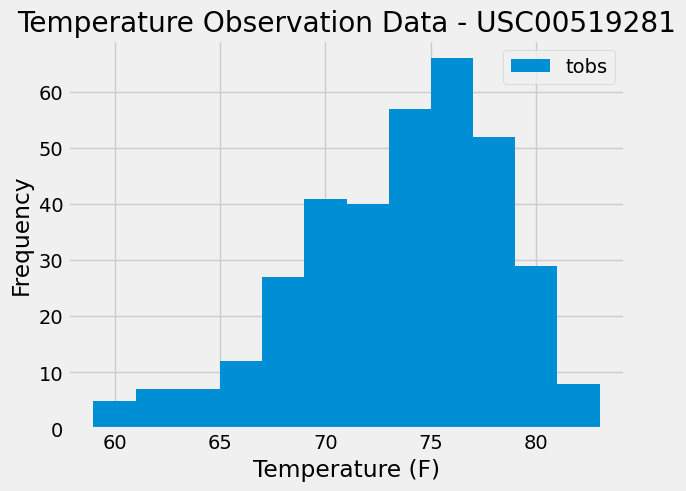

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == most_active).order_by(Measurement.date.asc())
temp_df = pd.DataFrame(results)
temp_df = temp_df.rename(
columns = {
    'date' : 'Date',
    'tobs' : 'Temperature'
})

plt.hist(temp_df['Temperature'], bins = 12, label = 'tobs')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data - {most_active}')
plt.legend()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()